In [1]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import cv2

from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

from torch.optim import lr_scheduler
from torch import tensor
from tqdm import tqdm

from utils import *
from learner import *
from data import *
from models import *
from criterion import *
from config import *

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard
%reload_ext autoreload
%autoreload 2

In [2]:
from torchviz import make_dot

In [3]:
plt.rcParams['figure.figsize'] = (20, 20)

In [4]:
model1 = MobileNetV2SkipAdd(pretrained=False)
model1.cuda()

MobileNetV2SkipAdd(
  (conv0): ConvBNReLU(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (conv1): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv2): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(

In [5]:
model1.load_state_dict(torch.load('mobilenetv2_edge_47.pth')['state_dict'])

<All keys matched successfully>

In [6]:
model2 = MobileNetV2SkipAdd()
model2.cuda()

MobileNetV2SkipAdd(
  (conv0): ConvBNReLU(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (conv1): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv2): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(

In [7]:
model2.load_state_dict(torch.load('mobilenetv2_no_edge_29.pth')['state_dict'])

<All keys matched successfully>

In [8]:
model1.cpu()
model2.cpu()

MobileNetV2SkipAdd(
  (conv0): ConvBNReLU(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (conv1): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv2): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(

## Load Data

In [11]:
train_img_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(0.3, 0.3, 0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_depth_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

valid_img_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_depth_transforsms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

ds = H5Dataset('/home/deman/dev/data/nyu_depth_v2_labeled.mat', 
               img_transforms=train_img_transforms,
               depth_transforms=train_depth_transforms)

dl = DataLoader(
            dataset=ds,
            batch_size=16,
            shuffle=True,
        )

In [12]:
data_iter = iter(dl)

In [23]:
images, depths = next(data_iter)

In [24]:
preds1 = model1(images)

In [25]:
preds2 = model2(images)

In [26]:
def draw_results(images, depths, preds1, preds2, device='cpu', 
                 means=[0.485, 0.456, 0.406], 
                 std=[0.229, 0.224, 0.225], 
                 num_samples=4, save_as=None):
    mean = torch.tensor(means).to(device).view(1, 3, 1, 1)
    std = torch.tensor(std).to(device).view(1, 3, 1, 1)
    images = images * std + mean
    images = images.cpu().numpy().transpose(0, 2, 3, 1)
    depths = depths.cpu().numpy().transpose(0, 2, 3, 1)
    preds1 = preds1.cpu().detach().numpy().transpose(0, 2, 3, 1)
    preds2 = preds2.cpu().detach().numpy().transpose(0, 2, 3, 1)
    
    fig, axs = plt.subplots(num_samples, 4)
    for i in range(num_samples):
        axs[i][0].axis('off')
        axs[i][0].title.set_text('Image')
        axs[i][0].imshow(images[i])
    
        axs[i][1].axis('off')
        axs[i][1].title.set_text('Groundtruth')
        axs[i][1].imshow(depths[i])
        
        axs[i][2].axis('off')
        axs[i][2].title.set_text('With edge loss')
        axs[i][2].imshow(preds1[i])
        
        axs[i][3].axis('off')
        axs[i][3].title.set_text('Without edge loss')
        axs[i][3].imshow(preds2[i])
        
    if save_as:
        plt.savefig(save_as)
        
    plt.show()

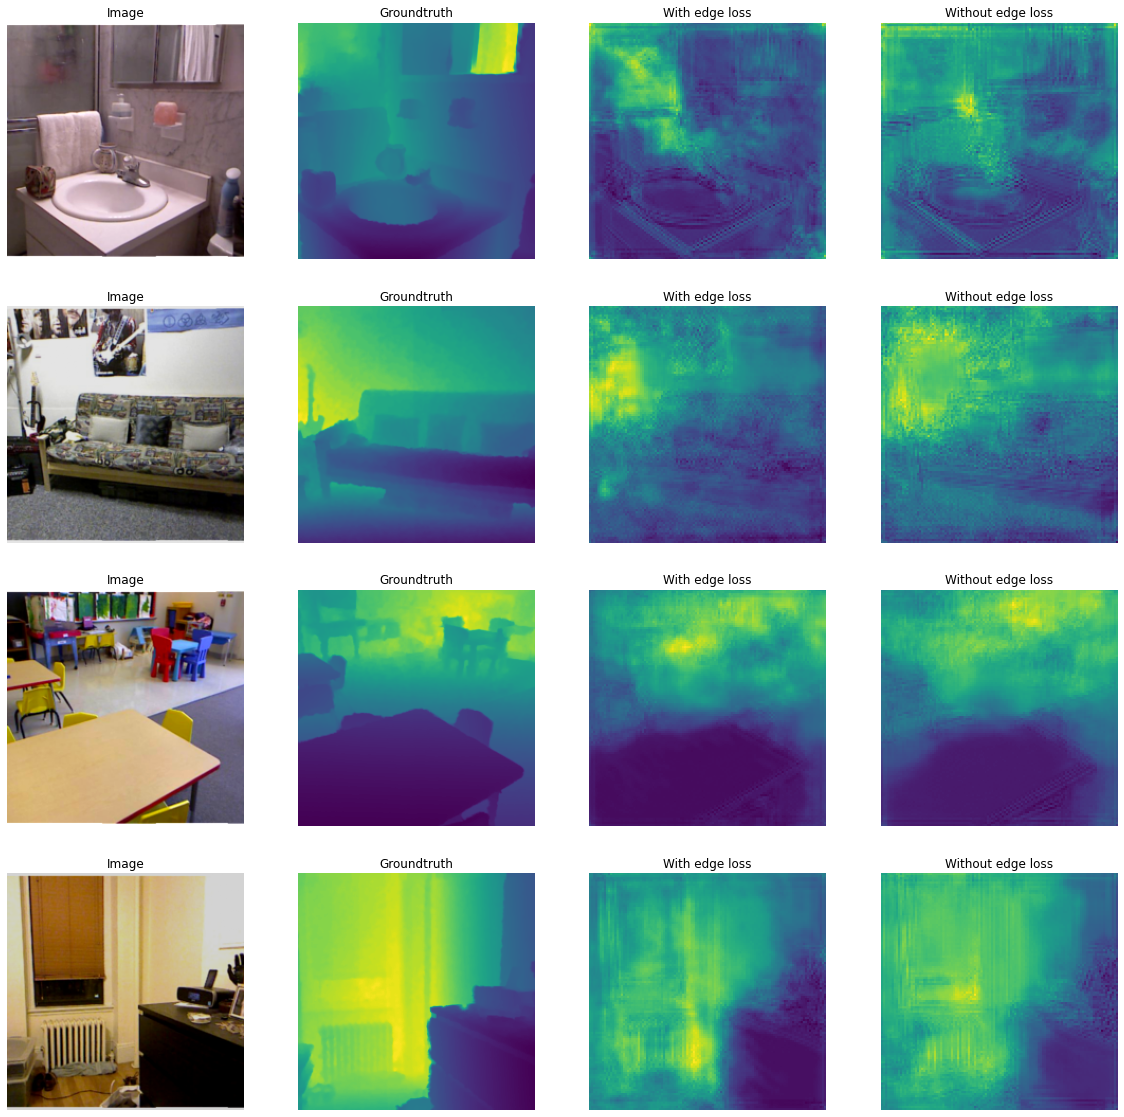

In [27]:
draw_results(images, depths, preds1, preds2, device='cpu', save_as='edge_comparison.png')